In [1]:
import numpy as np
import pandas as pd
import apmodule as ap #Notice the new import of our subject module
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

## 1. Load the Data
As usual we start by loading the returns data and the data on the signals we want to test. Since we want to build a multifactor model, let's load three signals:
* Gross Profitability Ratio (GP)
* E/P Ratio (EPQ)
* 12 Months Momentum (MOM12)

The idea would be to build a multifactor Moment/Value/Profitability model

In [2]:
# we load the returns
returns = pd.read_csv('Returns.zip', parse_dates=['date']).set_index(['id', 'date'])

# we load the market capitalization
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date'])

# we load the three factors
gp = pd.read_csv('GP.zip', parse_dates=['date']).set_index(['id', 'date'])
mom12 = pd.read_csv('MOM12.zip', parse_dates=['date']).set_index(['id', 'date'])
epq = pd.read_csv('EPQ.zip', parse_dates=['date']).set_index(['id', 'date'])

We can calculate the future returns by shifting the monthly returns by one observation.

In [3]:
fut_returns= returns.groupby('id')['return'].shift(-1).rename('fut_returns')
fut_returns.head()

id     date      
10000  1986-01-31   -0.297252
       1986-02-28    0.311436
       1986-03-31   -0.103797
       1986-04-30   -0.251873
       1986-05-30   -0.005038
Name: fut_returns, dtype: float64

Let's now create a DataFrame by joining all the elements.

In [4]:
db = gp.join(epq)
db = db.join(mom12)
db = db.join(fut_returns)
db.dropna(inplace=True)
db.head()

gp       epq     mom12  fut_returns
id    date                                                 
10001 1987-02-27 -0.719739  0.418686  0.072900     0.036139
      1987-03-31 -0.692694  0.410622 -0.243971    -0.040005
      1987-04-30 -0.691655  0.423818 -0.118392    -0.074108
      1987-05-29 -0.402479  1.025261 -0.146535     0.050150
      1987-06-30 -0.433225  0.968983 -0.232286     0.021053

There is a more coincise way to achieve this. The first command `gp.join(epq)` returns a DataFrame with its own join method, so we can simply concatenate the second command `.join(mom12)`. This, in turn, will return another DataFrame with its own join method, etc.

In [5]:
db = gp.join(epq).join(mom12).join(fut_returns).dropna()
db.head()

gp       epq     mom12  fut_returns
id    date                                                 
10001 1987-02-27 -0.719739  0.418686  0.072900     0.036139
      1987-03-31 -0.692694  0.410622 -0.243971    -0.040005
      1987-04-30 -0.691655  0.423818 -0.118392    -0.074108
      1987-05-29 -0.402479  1.025261 -0.146535     0.050150
      1987-06-30 -0.433225  0.968983 -0.232286     0.021053

## 2. Backtesting the Individual Factors
Before we build our multifactor model, let's backtest our individual factors. We can easily accomplish that by using our **`ap.backtesting()`** function. To **keep this notebook agile**, we will use a short time span unaffected by any major crisis: 1990 - 1995.

In [6]:
First_date = '1990-01-01'
Last_date = '1995-12-31'
Num_shares = 1000

In [7]:
gp_ret, gp_turn, gp_comp, gp_perf = ap.backtesting(db['gp'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
epq_ret, epq_turn, epq_comp, epq_perf = ap.backtesting(db['epq'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
mom_ret, mom_turn, mom_comp, mom_perf = ap.backtesting(db['mom12'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)

We will mainly **use data on the _Active_ performance** of each strategy. You may remember that the monthly active return of each strategy is contained in the first output of the function. For example

In [8]:
gp_ret.head()

,Portfolio,Benchmark,Active
date,,,
1990-01-31,0.013149,0.014581,-0.001432
1990-02-28,0.047312,0.026243,0.021069
1990-03-30,-0.002292,-0.027467,0.025175
1990-04-30,0.111289,0.086132,0.025157
1990-05-31,0.015255,-0.004755,0.020010


Let's **put the active return of the three strategies in a new DataFrame**. This is easy but requires a bit of coding gymnastics because they are all called "Active", so we **need to change the names**...

In [9]:
active = gp_ret['Active'].rename('gp').to_frame().join(epq_ret['Active'].rename('epq')).join(mom_ret['Active'].rename('mom12'))
active.head()

,gp,epq,mom12
date,,,
1990-01-31,-0.001432,0.001522,-0.002134
1990-02-28,0.021069,0.000111,0.005588
1990-03-30,0.025175,-0.010744,0.004344
1990-04-30,0.025157,0.000319,0.006114
1990-05-31,0.020010,-0.001913,0.008413


We could also **extract the performance measures** from the fourth output of each strategy, but it's much faster to simply **recalculate them** using our **`ap.diagnostics()`** function.

In [10]:
performance = ap.diagnostics(active)
performance

,gp,epq,mom12
Mean Return,0.035623,0.024389,0.023291
St. Dev.,0.057629,0.036418,0.053694
RR Ratio,0.618156,0.669698,0.433779
% Positive,0.541667,0.680556,0.611111
Worst Month,-0.040598,-0.036657,-0.049667
Best Month,0.035610,0.021381,0.040481
Max DrawDown,-0.155854,-0.045930,-0.103113


We can also **plot the portfolio value**. Remember that since our returns are logarithmic the value in time $T$ of 1 unit of wealth invested in time 0 is:

$$ P_{T} = \$1\times e^{r_{0,T}}$$

And the return of the asset from 0 to $T$, $r_{0,T}$, is:

$$ r_{0,T} = \sum_{t=0}^{T} r_{t} $$

So we can simply use [**`DataFrame.cumsum()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html) to calculate the cumulative sum of the monthly returns and then apply the Numpy exponential function.

<AxesSubplot:title={'center':'Active Portfolio Performance'}, xlabel='date', ylabel='Portfolio Value'>

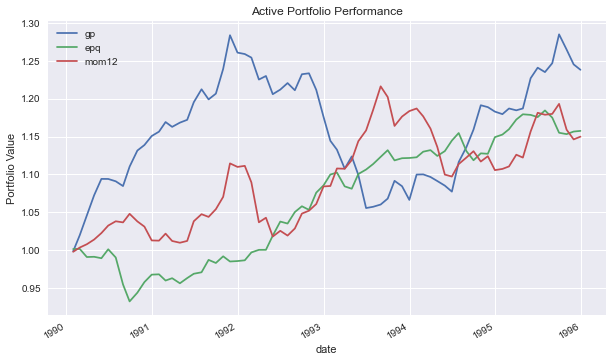

In [11]:
active.cumsum().apply(np.exp).plot(figsize=(10,6), 
                                   title = 'Active Portfolio Performance', 
                                   ylabel='Portfolio Value')

Here are some takeaways from this analysis:
1. The Profitability strategy (GP) outperforms the other two on a return basis.
1. The Value strategy (EPQ) outperforms on a risk-adjusted basis.
1. The Momentum Strategy (MOM12) performs better than the other two in specific periods of time such as 1993 - 1994.

At this point, a possible way forward would be to simply focus on the "best" factor. We know from theory that there are benefits in **combining multiple information signals**. For example we know that value tends to perfom poorly in certain market conditions, so diversifying our portfolio seems the right thing to do. A first possibility would be to calculate the aggregate score by averaging the three information signals, giving the same importance to factors even if they seem to have **different predictive power**. A second possibility is to use the different predictive power to find the **optimal combination** of factors.

## 3. Simple Aggregation
This method averages the different information signals. It's application is trivially simple. First of all we **calculate the average information signal**:

In [12]:
db['agg_model'] = (1/3)*db['gp'] + (1/3)*db['epq'] + (1/3)*db['mom12']
db.head()

gp       epq     mom12  fut_returns  agg_model
id    date                                                            
10001 1987-02-27 -0.719739  0.418686  0.072900     0.036139  -0.076051
      1987-03-31 -0.692694  0.410622 -0.243971    -0.040005  -0.175348
      1987-04-30 -0.691655  0.423818 -0.118392    -0.074108  -0.128743
      1987-05-29 -0.402479  1.025261 -0.146535     0.050150   0.158749
      1987-06-30 -0.433225  0.968983 -0.232286     0.021053   0.101158

If we want to be less pedestrian, and at least show _some_ coding skills we can get the same result by using the [**`DataFrame.mean()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html) with the `axis=1` parameter. This indicate means of columns and not of rows (`axis=0`).

In [13]:
db['agg_model2'] = db[['gp', 'epq', 'mom12']].mean(axis=1)
db.head()

gp       epq     mom12  fut_returns  agg_model  \
id    date                                                               
10001 1987-02-27 -0.719739  0.418686  0.072900     0.036139  -0.076051   
      1987-03-31 -0.692694  0.410622 -0.243971    -0.040005  -0.175348   
      1987-04-30 -0.691655  0.423818 -0.118392    -0.074108  -0.128743   
      1987-05-29 -0.402479  1.025261 -0.146535     0.050150   0.158749   
      1987-06-30 -0.433225  0.968983 -0.232286     0.021053   0.101158   

                  agg_model2  
id    date                    
10001 1987-02-27   -0.076051  
      1987-03-31   -0.175348  
      1987-04-30   -0.128743  
      1987-05-29    0.158749  
      1987-06-30    0.101158

Let's now backtest this `new information signal` and see **how it performs compared to the others**:

In [14]:
agg_ret, agg_turn, agg_comp, agg_perf = ap.backtesting(db['agg_model'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
active = active.join(agg_ret['Active'].rename('agg_model'))
performance = ap.diagnostics(active)
performance

,gp,epq,mom12,agg_model
Mean Return,0.035623,0.024389,0.023291,0.038477
St. Dev.,0.057629,0.036418,0.053694,0.058656
RR Ratio,0.618156,0.669698,0.433779,0.655983
% Positive,0.541667,0.680556,0.611111,0.569444
Worst Month,-0.040598,-0.036657,-0.049667,-0.040733
Best Month,0.035610,0.021381,0.040481,0.049019
Max DrawDown,-0.155854,-0.045930,-0.103113,-0.091681


<AxesSubplot:title={'center':'Active Portfolio Performance'}, xlabel='date', ylabel='Portfolio Value'>

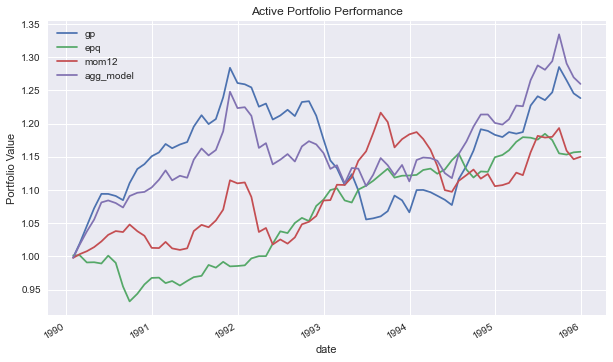

In [15]:
active.cumsum().apply(np.exp).plot(figsize=(10,6), 
                                   title = 'Active Portfolio Performance', 
                                   ylabel='Portfolio Value')

Here we see that **the "average" factor outperforms** the three "single-factor" strategies both on a return and risk-adjusted basis. **This is not always the case**, but here there is a clear benefit due to the strong underperformance of the "overall best" factor in specific periods of time.

## 4. Optimal Non-Linear Combination
#### AKA Two-steps Mean Variance Approach (MVA)
#### AKA Max IR process

The simple aggregation framework is **intuitive and easy to explain**, and this is the reason why it is chosen by many investment companies. The main drawback is that we may have situations where one of the factors has a much stronger predictive power than the others. In that case, combining all the signals with the same weight seems wasteful

A way to remedy this is to apply a 2-steps process where, after performing the backtesting of the individual factors we **use the performance of the portfolios** to find the optimal combination of factors. The process involves:
1. Step 1: Backtest the Individual Factors, take their active return and calculate the mean and the covariance matrix
1. Step 2: Use the Mean active return of each factor and the cov matrix in a Markowitz Mean-Variance Optimization

From the MV optimization we can take the weights of the portfolio with highest Sharpe Ratio (since we are using active returns this is actually the **highest Information Ratio**) and **apply these weights to the information signals**.

Weirdly enough Python does not have a main Mean-Variance optimization library. There are a number of possible candidates such as [pyportfolioopt](https://pyportfolioopt.readthedocs.io/en/latest/). To avoid having to use modules that are not in standard Anaconda distribution here we will code our own portfolio optimization function following this [very clear example](https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f).

As usual we will examine the construction of the function for learning purposes but then we will include it into our `apmodule` and you wil be able to use it from there.
___
### 4.1 Home-made portfolio optimization
A good place to find all the common optimization functionalities (to find the min or the max of a function, etc.) is the [optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html)  submodule of [scipy](https://docs.scipy.org/doc/scipy/index.html). So we can start by importing it:

In [16]:
import scipy.optimize as sco

Let's first refresh our memory on the mathematics of portfolio optimization. We want to find the portfolio composition, the vector of weights $w^{*}$, that maximizes the Sharpe ratio of the portfolio. 

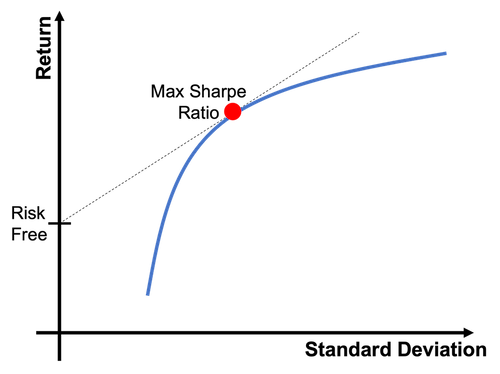

From our studies we know that the Sharpe Ratio ($S$) can be written as:

$$S = \frac{\bar{r_{p}} - r_{f}}{\sigma_{p}}$$

We also know that portfolio mean return and standard deviation are a function of:
* The vector of weights $w$
* The vector of the mean returns of each asset $\mu$
* The variance-covariance matrix $\Sigma$

So we can rewrite portfolio risk and return and the Sharpe ratio as:

$$\bar{r_{p}} = w^{T}\mu $$

$$\sigma_{p} = \sqrt{w^{T} \Sigma w}$$

$$S = \frac{w^{T}\mu - r_{f}}{\sqrt{w^{T} \Sigma w}}$$

Now that we have clear (more or less...) the nature of the problem we can build our function. Following the [example](https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f) we will break the function in three parts:
1. The first function, `portfolio_performance`, simply **calculates portfolio risk and return** as a function of the weights vector, returns vector and var-cov matrix.
1. The second function, `neg_sharpe_ratio`, calls the first function to calculate portfolio risk and return and then use these quantities to **calculate the Sharpe Ratio**. This gets multipled by minus 1 because **most optimizers work by "minimizing" functions**, to get the highest Sharpe Ratio we need to minimize $-S$.
1. Finally the third function, `max_sharpe_ratio`, calls the optimizer to find portfolio weights that minimize the negative sharpe.

In [17]:
# PART 1: Calculates portfolio risk and return as a function of the 
# weights vector, returns vector and var-cov matrix
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights.T, mean_returns)  
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

# PART 2: Calculates the sharpe ratio as a fucntion of weights vector, 
# returns vector, var-cov matrix and risk-free. 
# Notice that this function calls the previous one
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_std, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

# PART 3: Performs the optimization
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    
    #Extract the number of assets from the length of the returns vector
    num_assets = len(mean_returns)
    
    #Creates a tuple with the variables to be uses by the objective function
    args = (mean_returns, cov_matrix, risk_free_rate)
    
    #The Constrating that the sum of the weight has to be equal to one
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Individual weights between minus 100% and plus 100%. We allow for negative 
    # weights in case we have a factor that performs really poorly we may add it 
    # with negative weight
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    # This runs the actual minimization of the negative Sharpe
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    # This put the results in a series
    opt_weights = pd.Series(result['x'], index=mean_returns.index)
    return opt_weights

Let's now try this out by calculating the mean and var-cov matrix of our active returns:

In [18]:
mean_returns = active[['gp', 'epq', 'mom12']].mean()*12
mean_returns

gp       0.035623
epq      0.024389
mom12    0.023291
dtype: float64

In [19]:
cov_matrix = active[['gp', 'epq', 'mom12']].cov()*12
cov_matrix

,gp,epq,mom12
gp,0.003321,-0.000612,0.000880
epq,-0.000612,0.001326,-0.000121
mom12,0.000880,-0.000121,0.002883


We can now use the function to **calculate the optimal composition**:

In [20]:
opt_weights = max_sharpe_ratio(mean_returns, cov_matrix, 0)
opt_weights

gp       0.318561
epq      0.572062
mom12    0.109376
dtype: float64

Please notice that we are using active return and risk and we are assuming a risk free equal to zero. Under these conditions we are not actually maximizing the Sharpe Ratio but the Information Ratio

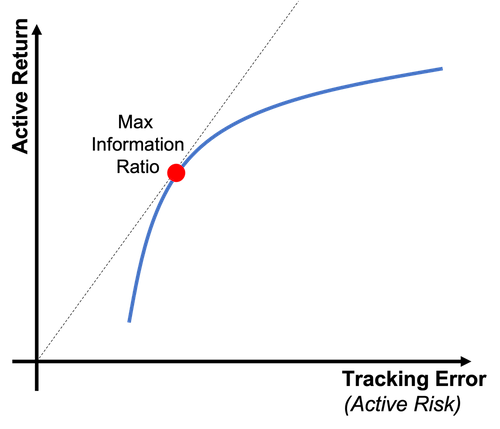

Now since **there is no bound to lazyness** let's create another function that combines the optimization with the calculation of mean returns and var-cov matrix:

In [21]:
def optimized_alpha_model(active_returns):
    
    #We calculate the optimization inputs
    mean_returns = active_returns.mean()*12
    cov_matrix = active_returns.cov()*12
    
    #We run the optimization
    opt_weights = max_sharpe_ratio(mean_returns, cov_matrix, 0)
    
    #We return the optimal weights
    return opt_weights

In this way we can take the active returns of the individual factors and directly calculate the optimal weights. All **these functions are part of the apmodule**. 

In [22]:
opt_weights = optimized_alpha_model(active[['gp', 'epq', 'mom12']])
opt_weights

gp       0.318561
epq      0.572062
mom12    0.109376
dtype: float64

We can now **apply these weights to the information signals** to create our multifactor signal

In [23]:
db['mva_model'] = db['gp']*opt_weights['gp'] + db['epq']*opt_weights['epq'] + db['mom12']*opt_weights['mom12']
db.head()

gp       epq     mom12  fut_returns  agg_model  \
id    date                                                               
10001 1987-02-27 -0.719739  0.418686  0.072900     0.036139  -0.076051   
      1987-03-31 -0.692694  0.410622 -0.243971    -0.040005  -0.175348   
      1987-04-30 -0.691655  0.423818 -0.118392    -0.074108  -0.128743   
      1987-05-29 -0.402479  1.025261 -0.146535     0.050150   0.158749   
      1987-06-30 -0.433225  0.968983 -0.232286     0.021053   0.101158   

                  agg_model2  mva_model  
id    date                               
10001 1987-02-27   -0.076051   0.018207  
      1987-03-31   -0.175348  -0.012449  
      1987-04-30   -0.128743   0.009166  
      1987-05-29    0.158749   0.442271  
      1987-06-30    0.101158   0.390904

And now we can backtest this new multifactor signal:

In [24]:
mva_ret, mva_turn, mva_comp, mva_perf = ap.backtesting(db['mva_model'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
active = active.join(mva_ret['Active'].rename('mva_model'))
performance = ap.diagnostics(active)
performance

,gp,epq,mom12,agg_model,mva_model
Mean Return,0.035623,0.024389,0.023291,0.038477,0.042169
St. Dev.,0.057629,0.036418,0.053694,0.058656,0.060079
RR Ratio,0.618156,0.669698,0.433779,0.655983,0.701893
% Positive,0.541667,0.680556,0.611111,0.569444,0.541667
Worst Month,-0.040598,-0.036657,-0.049667,-0.040733,-0.037571
Best Month,0.035610,0.021381,0.040481,0.049019,0.043214
Max DrawDown,-0.155854,-0.045930,-0.103113,-0.091681,-0.118426


<AxesSubplot:title={'center':'Active Portfolio Performance'}, xlabel='date', ylabel='Portfolio Value'>

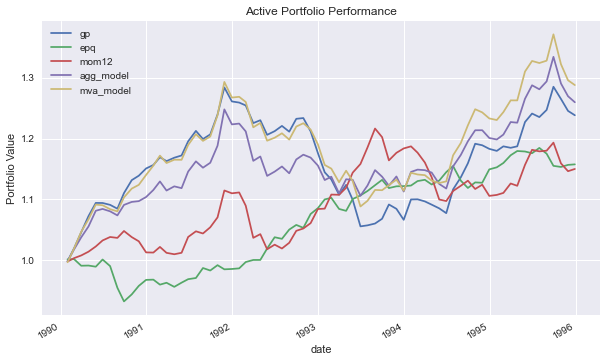

In [25]:
active.cumsum().apply(np.exp).plot(figsize=(10,6), 
                                   title = 'Active Portfolio Performance', 
                                   ylabel='Portfolio Value')

As you can see the MVA model performs better than the simple aggregation. Again, **this is not always the case**, but in this case it shows that there is value in combining the factors, and even more value in **giving more importance to the best factors**.

The simple model has a lower in-sample performance. This is to be expected in most cases, but is important to remember that this **may not translate in better out-of sample performance**. As we use the optimal weights in the future, the simple average may well outperform.

### Exercise 10.01
The possibility of building a succesful optimized alpha model **rests on the assumption** that the performance of the different information signals in the past **is indicative of their performance in the future**. In the example above we put ourselves in the shoes of a portfolio manager that in December 1995 has to build a model for the following year(s) choosing the weight of the diffetent signals based on their performance in the 1990 - 1995 period. The model invests heavily in the value factor due to its good risk-adjusted performance over this period. But **will this over-performance continue** in the future?

In this exercise you will have to **test the stability of the optimal weights** on an alpha model in time. You should repeat the process to estimate the weights of the optimized alpha model with the MVA methodology over the following three periods of time:
* 1996 - 2000
* 2001 - 2005
* 2006 - 2010

After estimating the optimal composition on the three sub periods **plot each composition as a pie chart** and think about what the results say **about the stability** of the optimal factor mix in time.

In [26]:
First_date = '1996-01-01'
Last_date = '2000-12-31'
gp_ret, gp_turn, gp_comp, gp_perf = ap.backtesting(db['gp'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
epq_ret, epq_turn, epq_comp, epq_perf = ap.backtesting(db['epq'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
mom_ret, mom_turn, mom_comp, mom_perf = ap.backtesting(db['mom12'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
active00 = gp_ret['Active'].rename('gp').to_frame().join(epq_ret['Active'].rename('epq')).join(mom_ret['Active'].rename('mom12'))
opt_weights00 = optimized_alpha_model(active00)
opt_weights00

gp       0.594214
epq      0.318370
mom12    0.087416
dtype: float64

In [27]:
First_date = '2001-01-01'
Last_date = '2005-12-31'
gp_ret, gp_turn, gp_comp, gp_perf = ap.backtesting(db['gp'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
epq_ret, epq_turn, epq_comp, epq_perf = ap.backtesting(db['epq'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
mom_ret, mom_turn, mom_comp, mom_perf = ap.backtesting(db['mom12'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
active05 = gp_ret['Active'].rename('gp').to_frame().join(epq_ret['Active'].rename('epq')).join(mom_ret['Active'].rename('mom12'))
opt_weights05 = optimized_alpha_model(active05)
opt_weights05

gp       1.504512e-01
epq      8.495488e-01
mom12    5.204170e-18
dtype: float64

In [28]:
First_date = '2006-01-01'
Last_date = '2010-12-31'
gp_ret, gp_turn, gp_comp, gp_perf = ap.backtesting(db['gp'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
epq_ret, epq_turn, epq_comp, epq_perf = ap.backtesting(db['epq'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
mom_ret, mom_turn, mom_comp, mom_perf = ap.backtesting(db['mom12'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
active10 = gp_ret['Active'].rename('gp').to_frame().join(epq_ret['Active'].rename('epq')).join(mom_ret['Active'].rename('mom12'))
opt_weights10 = optimized_alpha_model(active10)
opt_weights10

gp       4.096125e-01
epq      5.903875e-01
mom12    1.856154e-16
dtype: float64

In [29]:
optimal = opt_weights00.rename('1996-2000').to_frame().join(opt_weights05.rename('2001-2005')).join(opt_weights10.rename('2006-2010'))
optimal

,1996-2000,2001-2005,2006-2010
gp,0.594214,1.504512e-01,4.096125e-01
epq,0.318370,8.495488e-01,5.903875e-01
mom12,0.087416,5.204170e-18,1.856154e-16


array([<AxesSubplot:ylabel='1996-2000'>, <AxesSubplot:ylabel='2001-2005'>,
       <AxesSubplot:ylabel='2006-2010'>], dtype=object)

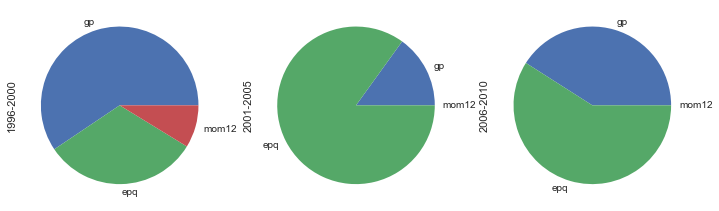

In [30]:
optimal.plot(kind='pie',
             subplots=True,
             legend=False,
             figsize=(12,6))

___
#### Coding issue
In the solution above we have repeated the same lines of code multiple times. This should be avoided when possible, within reason. Here is a solution with a more elegant and concise loop:

In [31]:
start_dates = ['1996-01-01', '2001-01-01', '2006-01-01']
end_dates = ['2000-12-31', '2005-12-31', '2010-12-31']

optimized = pd.DataFrame(index=['gp', 'epq', 'mom12'])

for n in range(3):
    
    #We select the appropriate start and end date for each iteration
    First_date = start_dates[n]
    Last_date = end_dates[n]
    
    #We run the ususal code
    gp_ret, gp_turn, gp_comp, gp_perf = ap.backtesting(db['gp'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
    epq_ret, epq_turn, epq_comp, epq_perf = ap.backtesting(db['epq'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
    mom_ret, mom_turn, mom_comp, mom_perf = ap.backtesting(db['mom12'], returns, market_cap, start=First_date, end=Last_date, N=Num_shares)
    active_n = gp_ret['Active'].rename('gp').to_frame().join(epq_ret['Active'].rename('epq')).join(mom_ret['Active'].rename('mom12'))
    opt_weights_n = optimized_alpha_model(active_n)
    
    #We build s string with the first and last year of the sample used in each loop
    name = First_date[0:4] + '-' + Last_date[0:4]
    
    #We store the results in our output DataFrame using the period name
    optimized = optimized.join(opt_weights_n.rename(name))
    
optimized

,1996-2000,2001-2005,2006-2010
gp,0.594214,1.504512e-01,4.096125e-01
epq,0.318370,8.495488e-01,5.903875e-01
mom12,0.087416,5.204170e-18,1.856154e-16


___
## 5. Advanced Topic: Walkforward Model
From the exercise you have seen that the optimal composition of the multifactor model **changes in time** quite a bit. **It is unrealistic** to think that we can use backtesting results from the last 5 years to build a multifactor model that we will use for the next five years. 

In practice we would either choose a fixed equally weighted multifactor model where we give the same weight to each factor, or we could use an optimized model built with a **walkforward approach** where in each period we use the performance of the factor from the previous $T$ months to calculate the optimal composition. The $T$ parameter is called the _learning period_.

Here we build a simple function that does exactly this. This function is included in the `apmodule`.

In [32]:
def walkforward_alpha_model(active, T):
    
    #We create an empty DataFrame with the same columns as the input
    model = pd.DataFrame(columns=active.columns)
    
    #We take the number of rows in the input
    n_rows = active.shape[0]
    
    #We start the loop
    for n in range(n_rows - T + 1):
        
        #We take a portion of the input from row n to n+T
        active_t = active.iloc[n:n+T,:]
        
        #We run the factor optimization function
        weights = optimized_alpha_model(active_t)
        
        #We appent the results to the output DataFrame
        model = model.append(weights,ignore_index=True)
    
    #We use a portion of the index of the input as the index of the output
    model = model.set_index(active.index[T-1:])
        
    #We return the output
    return model

Now that we have the function we will simply backtest the three factors **over the entire time period** available.

In [33]:
gp_ret, gp_turn, gp_comp, gp_perf = ap.backtesting(db['gp'], returns, market_cap, N=Num_shares)
epq_ret, epq_turn, epq_comp, epq_perf = ap.backtesting(db['epq'], returns, market_cap, N=Num_shares)
mom_ret, mom_turn, mom_comp, mom_perf = ap.backtesting(db['mom12'], returns, market_cap, N=Num_shares)

active_tot = gp_ret['Active'].rename('gp').to_frame().join(epq_ret['Active'].rename('epq')).join(mom_ret['Active'].rename('mom12'))

We can then pass the DataFrame with the active return to the walkforward function and **estimate, every month, the optimal composition** of the multifactor model using the **previous $T=60$ months** of active returns.

In [34]:
wf_model= walkforward_alpha_model(active_tot,60)
wf_model.head()

,gp,epq,mom12
date,,,
1984-12-31,0.338302,0.591488,0.070210
1985-01-31,0.357494,0.584938,0.057568
1985-02-28,0.333919,0.583741,0.082339
1985-03-29,0.330850,0.583850,0.085300
1985-04-30,0.330734,0.582941,0.086325


We can better **visualize the evolution** of the multifactor model with an area plot.

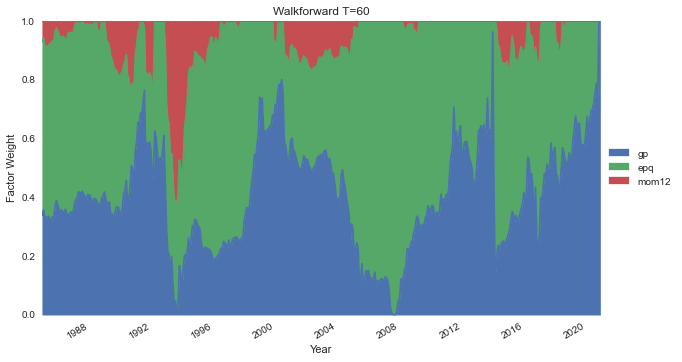

In [35]:
wf_model.plot(figsize=(10,6),
              kind='area',
              ylabel='Factor Weight',
              xlabel='Year',
              title='Walkforward T=60',
              ylim=[0,1],
              xlim=[wf_model.index.min(), wf_model.index.max()])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We could now in theory build an investment strategy where **every month we combine our three information signals with different weights** based on their performance over the previous 5 years. Of course we could also use shorter or longer learning periods...